# Our First ever contestant
## Custom ResNet20 Architecture

In this notebook, we will explore a Custom ResNet20 Architecture. The decision to use ResNet20 comes from its unique structure, which is often overlooked in favor of more modern or larger variants like ResNet50 or ResNet101. This choice provides a deeper understanding of how residual networks operate and how their principles can be applied even in simpler, smaller architectures and taking under consideration our GPU resource contraints.

The goal of this implementation is to closely mimic the original ResNet architecture as described in the seminal paper Deep Residual Learning for Image Recognition by He et al. The parameters and algorithms used in this notebook are chosen to reflect the original ResNet design, though not completely because of GPU resource contraints. While these settings may not be the most optimized in today's standards, they are chosen to preserve the intent and logic behind the original paper, making it a great learning tool for newcomers to deep learning.

Reference: He, K., Zhang, X., Ren, S., & Sun, J. (2015). Deep Residual Learning for Image Recognition. arXiv. https://arxiv.org/abs/1512.03385



In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

CIFAR-10 is a popular dataset used for training machine learning models, consisting of 60,000 32x32 color images in 10 different classes. In this section, we will load the CIFAR-10 dataset using TensorFlow and PyTorch. The dataset is split into 50,000 training images and 10,000 test images.

- **Normalization & Augmentation:** Applies transformations like random cropping, flipping, and normalization.  
- **Dataset Download:** Checks if CIFAR-10 exists locally; downloads if missing.  
- **Test Loader:** Loads test data with transformations and creates a DataLoader.  
- **Train Loader:** Loads training data, applies transformations, and splits into train/validation sets.  
- **Sampling & DataLoaders:** Uses `SubsetRandomSampler` to split and create train/validation loaders.  

In [23]:
def data_loader(data_dir,
                    batch_size,
                    random_seed=42,
                    valid_size=0.1,
                    shuffle=True,
                    test=False):

        normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )

        # define transforms
        transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
        download = not os.path.exists(os.path.join(data_dir, "cifar-10-batches-py"))
        print(download)
        if test:
            dataset = datasets.CIFAR10(
              root=data_dir, train=False,
              download=download, transform=transform,
            )

            data_loader = torch.utils.data.DataLoader(
                dataset, batch_size=batch_size, shuffle=shuffle
            )

            return data_loader

        # load the dataset
        train_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=download, transform=transform,
        )


        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = int(np.floor(valid_size * num_train))

        if shuffle:
            np.random.seed(42)
            np.random.shuffle(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=train_sampler,num_workers=2,pin_memory=True)

        valid_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=valid_sampler)

        return (train_loader, valid_loader)
train_loader, valid_loader = data_loader(data_dir='/kaggle/working/cifar10',
                                             batch_size=128)

test_loader = data_loader(data_dir='/kaggle/working/cifar10',
                                  batch_size=128,
                                  test=True)

False
False


A Residual Block is the fundamental building block of the ResNet architecture, designed to solve the vanishing gradient problem by introducing skip connections. These skip connections allow the input to bypass the convolutional layers and be added directly to the output, creating a shortcut path for gradients during backpropagation. This helps the network learn residual mappings, improving the model's performance and convergence.

In [24]:
class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
            super(ResidualBlock, self).__init__()
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.relu=nn.ReLU()
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.downsample = downsample
            self.out_channels = out_channels
            #self.skip_add = nn.quantized.FloatFunctional()
        def forward(self, x):
            residual = x
            y = self.conv1(x)
            y = self.bn1(y)
            y = self.relu(y)
            y = self.conv2(y)
            y = self.bn2(y)
            if self.downsample:
                residual = self.downsample(x)
            y += residual
            y = self.relu(y)
            return y

The ResNet class implements the ResNet architecture using PyTorch's nn.Module. It starts with a convolutional layer followed by batch normalization and ReLU activation. The network is built using residual blocks, created by the _make_layer function, which constructs layers of blocks with skip connections. The forward method defines the flow of the input through the network, ending with an adaptive average pooling layer and a fully connected layer for classification.

In [25]:
import torch.nn.init as init

class ResNet(nn.Module):
        def __init__(self, block, layers, num_classes = 10):
            super(ResNet, self).__init__()
            self.inplanes = 16
            #self.quant = torch.quantization.QuantStub()
            self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1)
            self.bn1 = nn.BatchNorm2d(16)
            self.relu=nn.ReLU()
            #self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
            self.layer0 = self._make_layer(block, 16, layers[0], stride = 1)
            self.layer1 = self._make_layer(block, 32, layers[1], stride = 2)
            self.layer2 = self._make_layer(block, 64, layers[2], stride = 2)
            self.avgpool = nn.AdaptiveAvgPool2d(1)
            self.fc = nn.Linear(64, num_classes)
            self._initialize_weights()  # Apply He initialization
            #self.dequant = torch.quantization.DeQuantStub()
        def _initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    if m.bias is not None:
                        init.zeros_(m.bias)

        def _make_layer(self, block, planes, blocks, stride=1):
            downsample = None
            if stride != 1 or self.inplanes != planes:

                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes),
                )
            layers = []
            layers.append(block(self.inplanes, planes, stride, downsample))
            self.inplanes = planes
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)

        def forward(self, x):
            #x = self.quant(x)
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            #x = self.maxpool(x)
            x = self.layer0(x)
            x = self.layer1(x)
            x = self.layer2(x)

            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
            #x = self.dequant(x)
            return x

In the original ResNet paper, the authors used 10 classes for CIFAR-10, 128 batches per epoch, and a learning rate of 0.1, adjusted via step decay. For our implementation, we set num_classes = 10, num_epochs = 10, and a batch_size = 128 to balance memory usage and training speed. The original ResNet used SGD with momentum, but we opted for Adam here with a learning rate of 0.001 and a scheduler that reduces it at milestones for stable training. Due to limited computational resources, we kept the model lightweight, using Adam optimizer for faster convergence and ensuring it runs efficiently even on devices with constrained memory.

In [ ]:
# Hyperparameters
num_classes = 10
num_epochs = 10
batch_size = 128
learning_rate = 0.001

# Model
model = ResNet(ResidualBlock, [3, 3, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.06,
    momentum=0.9,
    weight_decay=5e-4
)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,7], gamma=0.2)

print(model)

In [ ]:
#Optional
#from google.colab import drive

#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The training loop includes model checkpointing, which saves the model, optimizer, and scheduler states every two epochs to allow resuming training if interrupted. It also implements early stopping based on validation accuracy, halting training after three consecutive epochs of no improvement. Additionally, the loop ensures efficient memory management by clearing tensors and invoking garbage collection after each batch.

In [28]:
import gc
import time

checkpoint_path = "/kaggle/working/resnet_checkpoint3.pth"


start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
total_step = len(train_loader)
best_val = -1
tolerance = 3
t = 0
for epoch in range(start_epoch, num_epochs):
    t = time.time()
    for i, (images, labels) in enumerate(train_loader):
        if total_step/2 == i+1:
          print("half way there")
        #Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    scheduler.step()
    if (epoch + 1) % 2 == 0:
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict()
        }, os.path.join(os.path.dirname(checkpoint_path), f"resnet_checkpoint3_{epoch}.pth"))
        print(f"Checkpoint saved at epoch {epoch+1}")
    print ('epoch {}, loss: {:.4f} Time(sec): {:.1f}'.format(epoch+1, loss.item(), time.time()-t))

    #Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

    val_acc = 100 * correct / total
    print('val acc: {} %'.format( val_acc))
    if val_acc < best_val:
        tolerance -= 1
    else:
        tolerance = 3
    if (tolerance == 0):
        print("early stopping")
        break

half way there
epoch 1, loss: 1.7865 Time(sec): 80.1
val acc: 46.6 %
half way there
Checkpoint saved at epoch 2
epoch 2, loss: 1.0558 Time(sec): 79.6
val acc: 60.04 %
half way there
epoch 3, loss: 1.0349 Time(sec): 79.3
val acc: 69.06 %
half way there
Checkpoint saved at epoch 4
epoch 4, loss: 0.7262 Time(sec): 79.5
val acc: 71.68 %
half way there
epoch 5, loss: 0.6014 Time(sec): 77.9
val acc: 77.08 %
half way there
Checkpoint saved at epoch 6
epoch 6, loss: 0.5601 Time(sec): 77.6
val acc: 78.1 %
half way there
epoch 7, loss: 0.7686 Time(sec): 78.0
val acc: 79.92 %
half way there
Checkpoint saved at epoch 8
epoch 8, loss: 0.5533 Time(sec): 79.2
val acc: 80.42 %
half way there
epoch 9, loss: 0.4961 Time(sec): 77.6
val acc: 81.08 %
half way there
Checkpoint saved at epoch 10
epoch 10, loss: 0.5008 Time(sec): 78.6
val acc: 81.58 %


We acheived validation accuracy of 81.58% at epoch 10.

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_labels):
      cm = confusion_matrix(y_true, y_pred)
      plt.figure(figsize=(8, 6))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
      plt.xlabel('Predicted Label')
      plt.ylabel('True Label')
      plt.show()

We finally test the last checkpoint at epoch 10(Here it is saved as 9 since it started at 0).

We acheived 81% accuracy which is  suboptimal, but very good considering 10 epochs and a large batch size. Additionally a larger dataset is needed for better results.

Next we will quantize this model and put it in a challenge against other models.

<ipython-input-30-66e6e58f4f50>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/resnet_checkpoint3_9.pth', map_location=device) #me

test Accuracy : 81.23 %


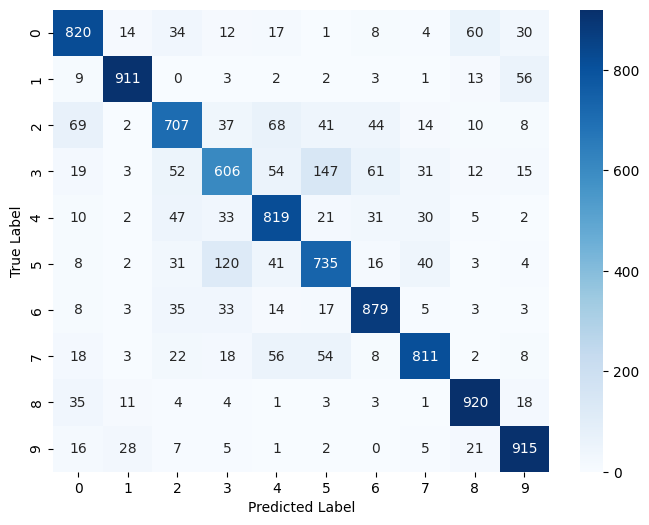

In [30]:
checkpoint = torch.load('/kaggle/working/resnet_checkpoint3_9.pth', map_location=device) #means epoch 10
model.load_state_dict(checkpoint["model_state"])
y_pred = []
y_true = []
model.to(device)
model.eval()
with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        acc =correct / total
        print('test Accuracy : {} %'.format(acc*100))
plot_confusion_matrix(y_true, y_pred, range(0,10))